In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import seaborn as sns
from tqdm import trange
import xarray as xr

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.diverging'] = 'vlag'
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False

In [3]:
dims = ['alpha_x', 'alpha_y', 'beta_x', 'beta_y']
eps_labels = [r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$']
twiss_labels = [r'$\alpha_x$', r'$\alpha_y$', r'$\beta_x$', r'$\beta_y$']  
twiss_labels_dict = {dim: label for dim, label in zip(dims, twiss_labels)}

Load the data.

In [4]:
alpha_xs = np.loadtxt('_output/data/alpha_xs.dat')
alpha_ys = np.loadtxt('_output/data/alpha_ys.dat')
beta_xs = np.loadtxt('_output/data/beta_xs.dat')
beta_ys = np.loadtxt('_output/data/beta_ys.dat')
alpha_x_true, alpha_y_true, beta_x_true, beta_y_true = np.loadtxt('_output/data/true_twiss.dat')
eps_x_true, eps_y_true = 1e6 * np.loadtxt('_output/data/true_emittances.dat')
eps_1_true = eps_x_true
eps_2_true = eps_y_true
eps_true = np.array([eps_x_true, eps_y_true, eps_1_true, eps_2_true])

In [5]:
def load_pickled_file(filename):
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()
    return data

def load_data(filename):
    data = load_pickled_file(filename)
    data = np.array(data)
    data *= 1e6
    data = xr.DataArray(
        data, 
        dims=dims+['emittance'], 
        coords={'alpha_x': alpha_xs, 
                'alpha_y': alpha_ys, 
                'beta_x': beta_xs, 
                'beta_y': beta_ys}
    )
    return data

In [6]:
fail_rates = np.array(load_pickled_file('_output/data/fail_rates.pkl'))
fail_rates = xr.DataArray(
    fail_rates,
    dims=dims,
    coords={'alpha_x': alpha_xs, 
            'alpha_y': alpha_ys, 
            'beta_x': beta_xs, 
            'beta_y': beta_ys},
)
means = load_data('_output/data/emittance_means.pkl')
stds = load_data('_output/data/emittance_stds.pkl')
errs = eps_true - means
frac_stds = stds / eps_true
frac_errs = errs / eps_true

Plot.

In [7]:
n = len(beta_xs)

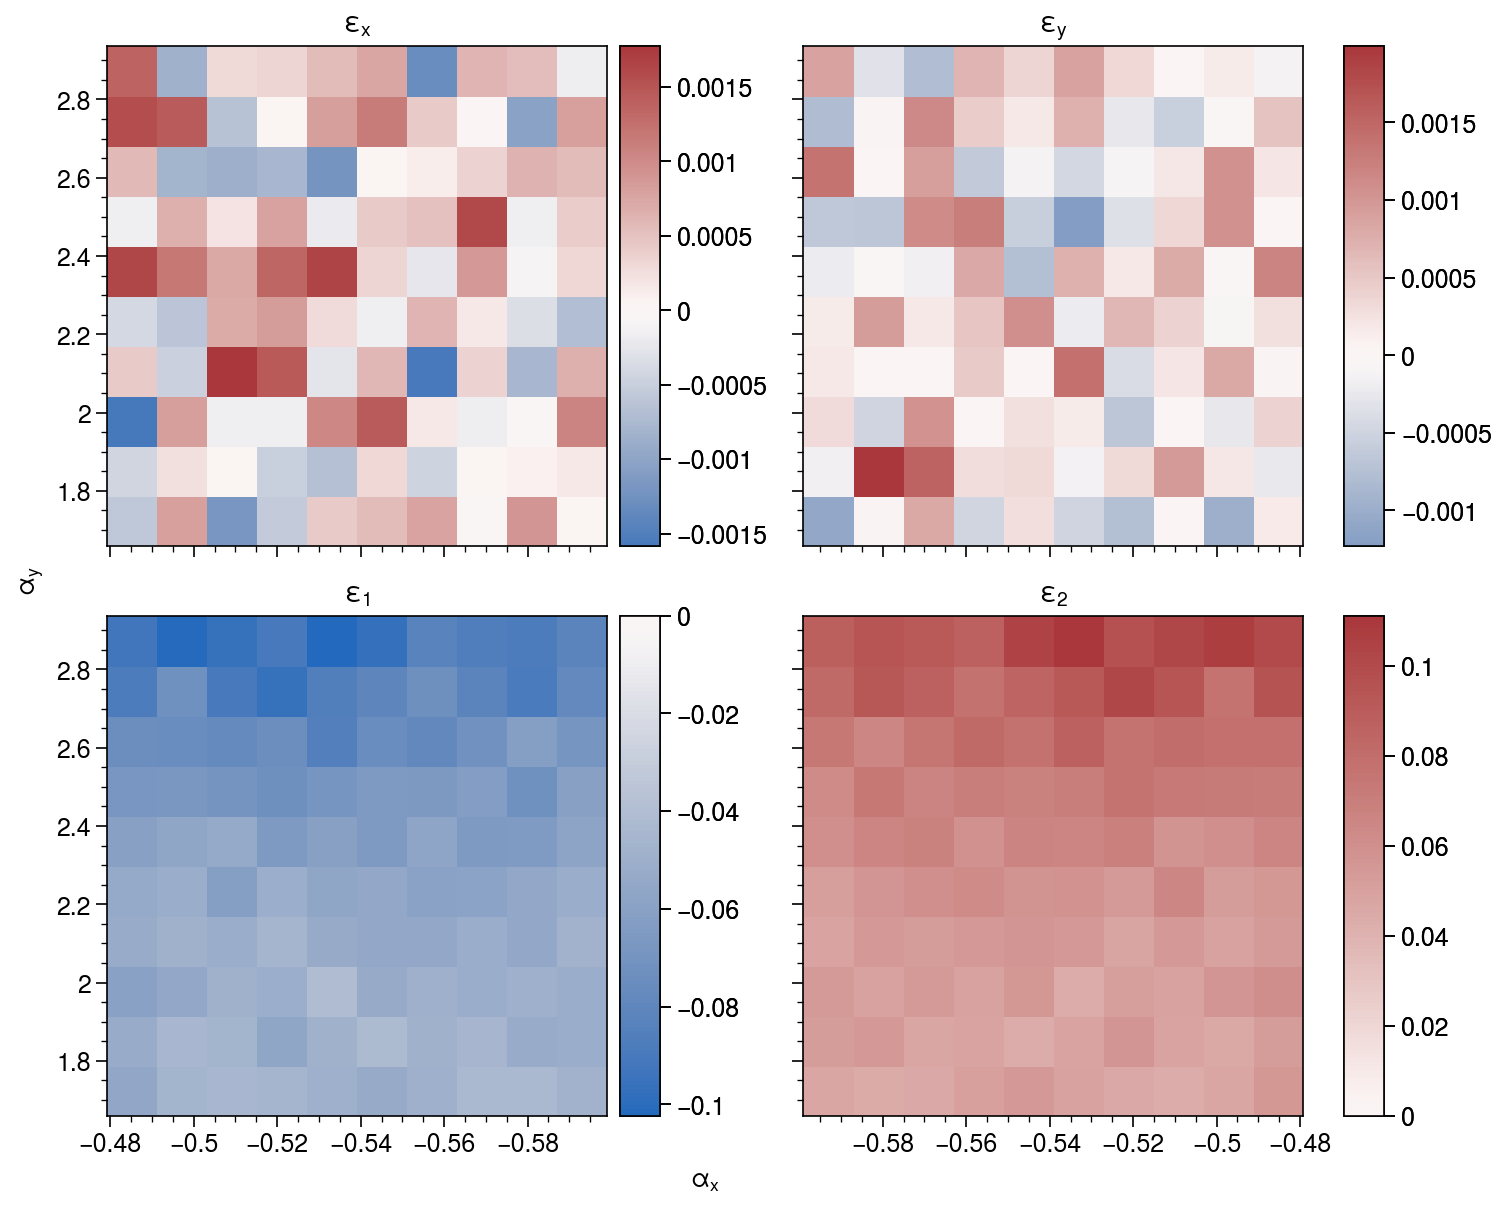

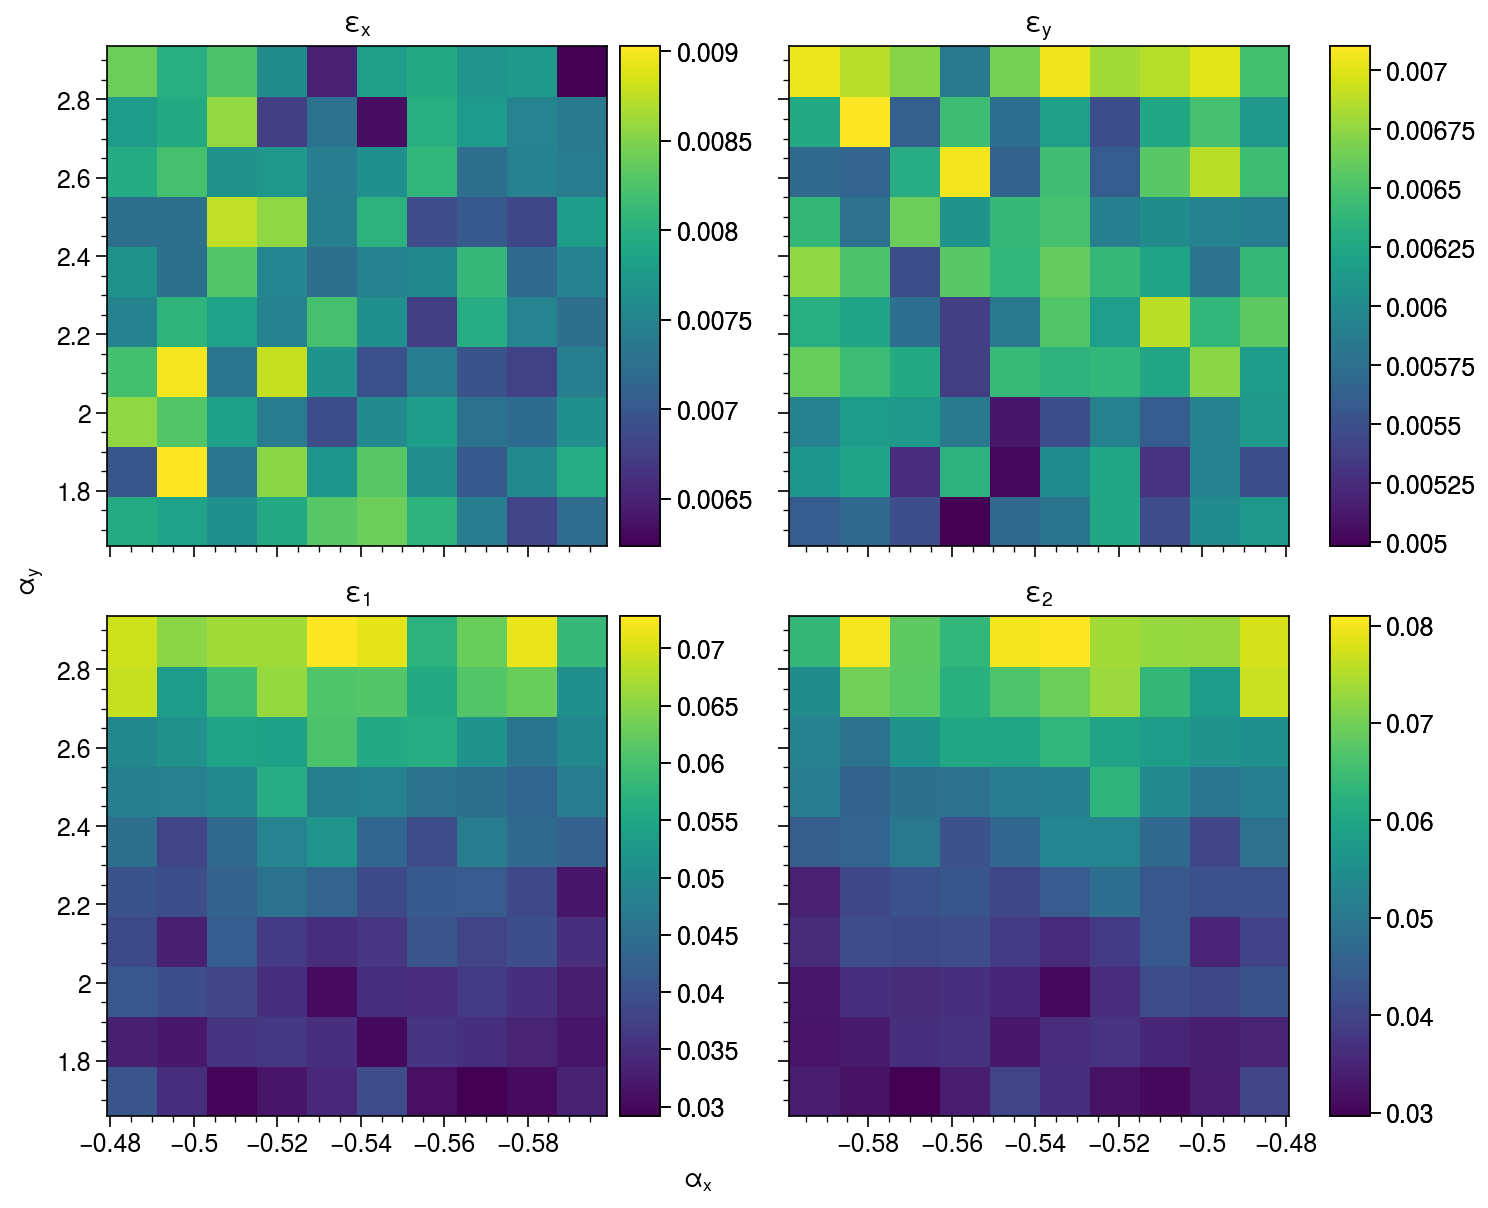

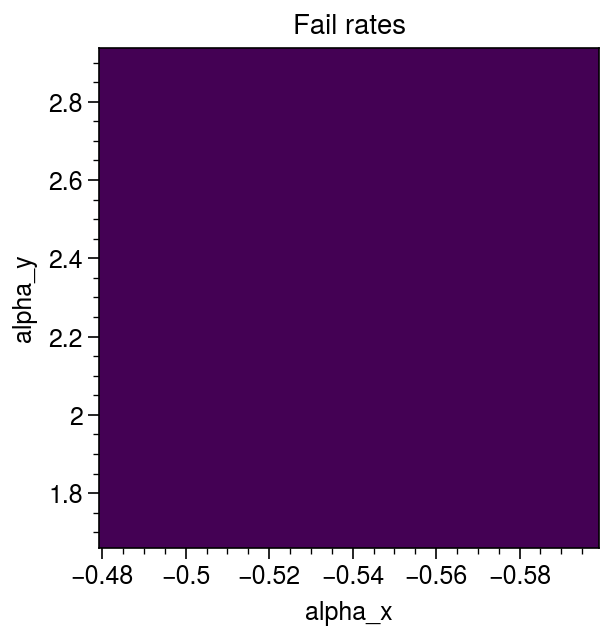

In [8]:
dim1 = 'alpha_x'
dim2 = 'alpha_y'
shared_norm = False

for diverging, data in zip([True, False], [frac_errs, frac_stds]):

    idx = {dim: n//2 for dim in dims if dim not in [dim1, dim2]}
    H = data.isel(idx)

    vmin = vmax = None
    if shared_norm:
        vmin = np.nanmin(H)
        vmax = np.nanmax(H)
        vmax = max(abs(vmax), abs(vmin))
        vmin = -vmax

    fig, axes = pplt.subplots(ncols=2, nrows=2, )
    for i, (ax, label) in enumerate(zip(axes, eps_labels)):
        ax.set_title(label)
        ax.pcolormesh(
            data.coords[dim1], data.coords[dim2], H[:, :, i].T, 
            vmin=vmin, vmax=vmax, 
            diverging=data is frac_errs,
            colorbar=True,
        )
    axes.format(xlabel=twiss_labels_dict[dim1], ylabel=twiss_labels_dict[dim2])
    plt.show()
    
fig, ax = pplt.subplots()
idx = {dim: n//2 for dim in dims if dim not in [dim1, dim2]}
ax.pcolormesh(fail_rates.coords[dim1], fail_rates.coords[dim2], fail_rates.isel(idx).T)
ax.set_title('Fail rates')
plt.show()

In [9]:
def mismatch_parameter(alpha1, beta1, alpha2, beta2):
    gamma1 = (1.0 + alpha1**2) / beta1
    gamma2 = (1.0 + alpha2**2) / beta2
    return beta1 * gamma2 - 2.0 * alpha1 * alpha2 + gamma1 * beta2

In [10]:
Mx = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
My = np.zeros((len(alpha_xs), len(alpha_ys), len(beta_xs), len(beta_ys)))
for i, alpha_x in enumerate(alpha_xs):
    for k, beta_x in enumerate(beta_xs):
        for j, alpha_y in enumerate(alpha_ys):
            for l, beta_y in enumerate(beta_ys): 
                Mx[i, j, k, l] = mismatch_parameter(alpha_x, beta_x, alpha_x_true, beta_x_true)
                My[i, j, k, l] = mismatch_parameter(alpha_y, beta_y, alpha_y_true, beta_y_true)
M = Mx + My

In [11]:
def correct_xlim(ax):
    xlim = ax.get_xlim()
    if xlim[1] < xlim[0]:
        ax.set_xlim(list(reversed(ax.get_xlim())))

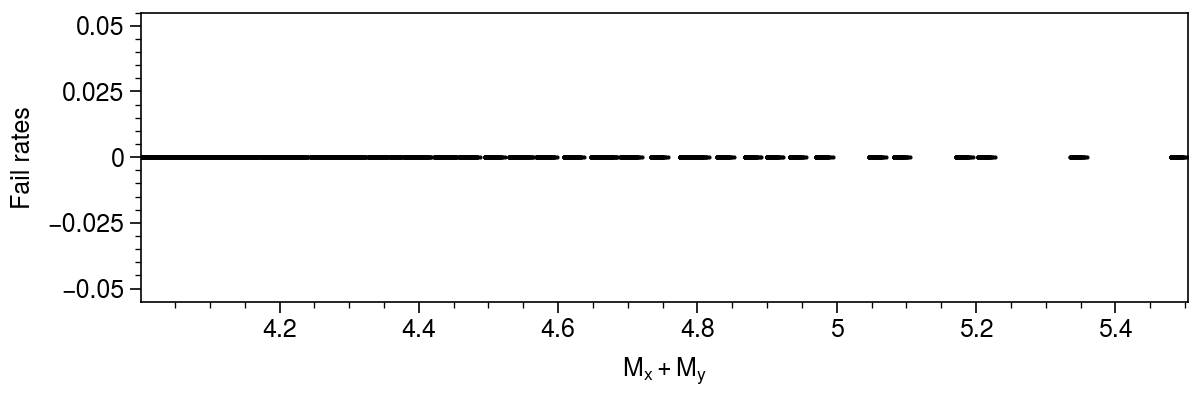

In [12]:
fig, ax = pplt.subplots(figsize=(6.0, 2.0))
ax.plot(M.ravel(), fail_rates.values.ravel(), color='black', lw=0, marker='.', ms=1)
ax.format(xlabel=r'$M_x + M_y$', ylabel='Fail rates')
correct_xlim(ax)
plt.show()

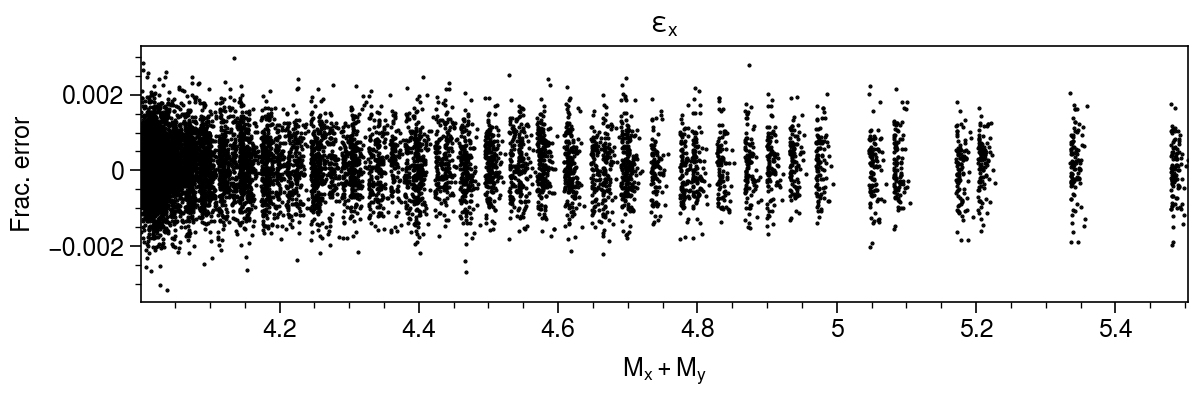

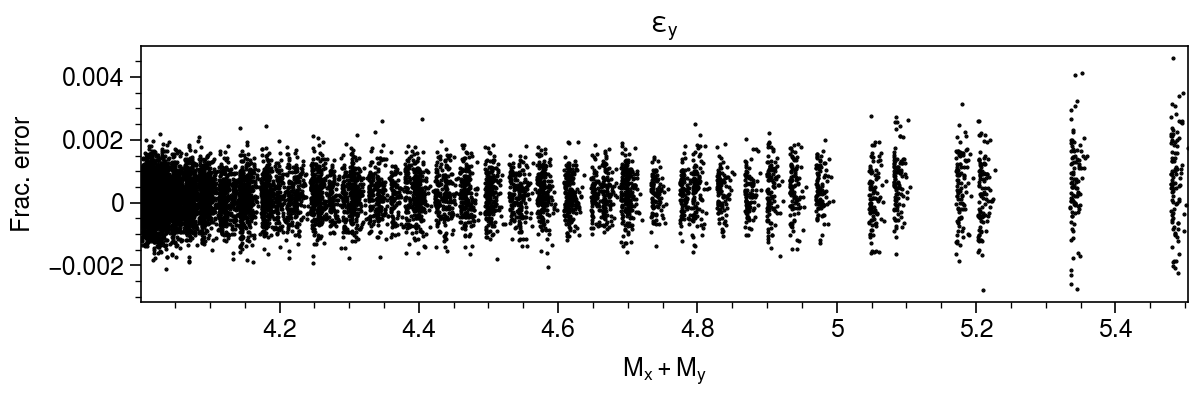

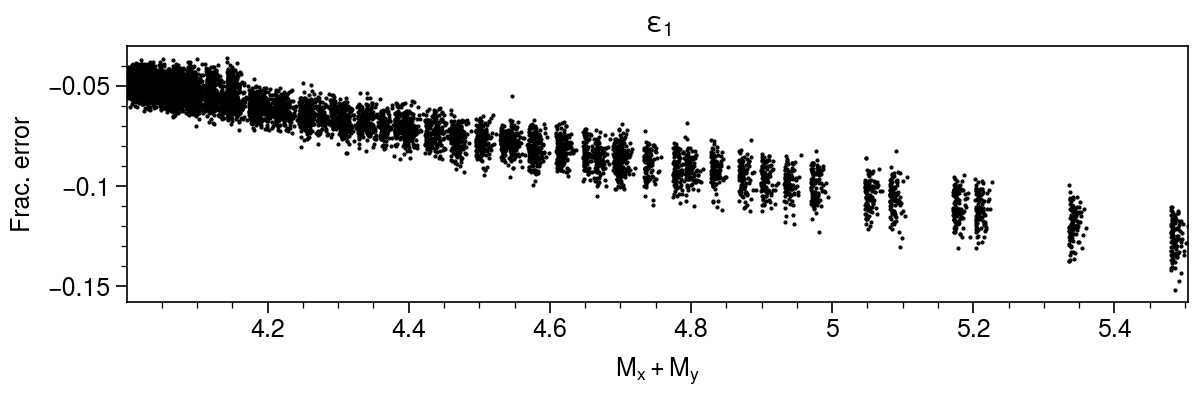

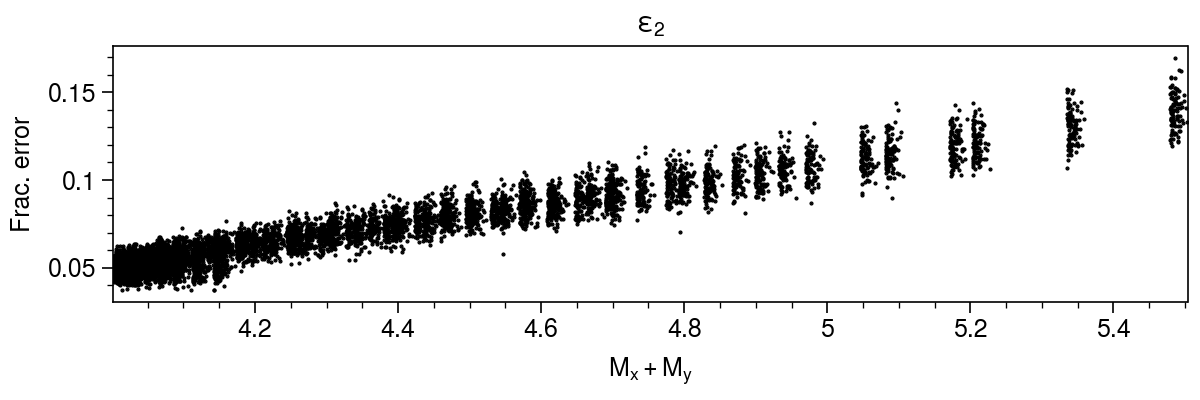

In [13]:
for i, eps_label in enumerate(eps_labels):
    fig, ax = pplt.subplots(figsize=(6.0, 2.0))
    ax.plot(M.ravel(), frac_errs[..., i].values.ravel(), color='black', lw=0, marker='.', ms=1)
    ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. error', title=eps_label)
    correct_xlim(ax)
    plt.show()

In [14]:
cmap = pplt.Colormap('mono', left=0.4)

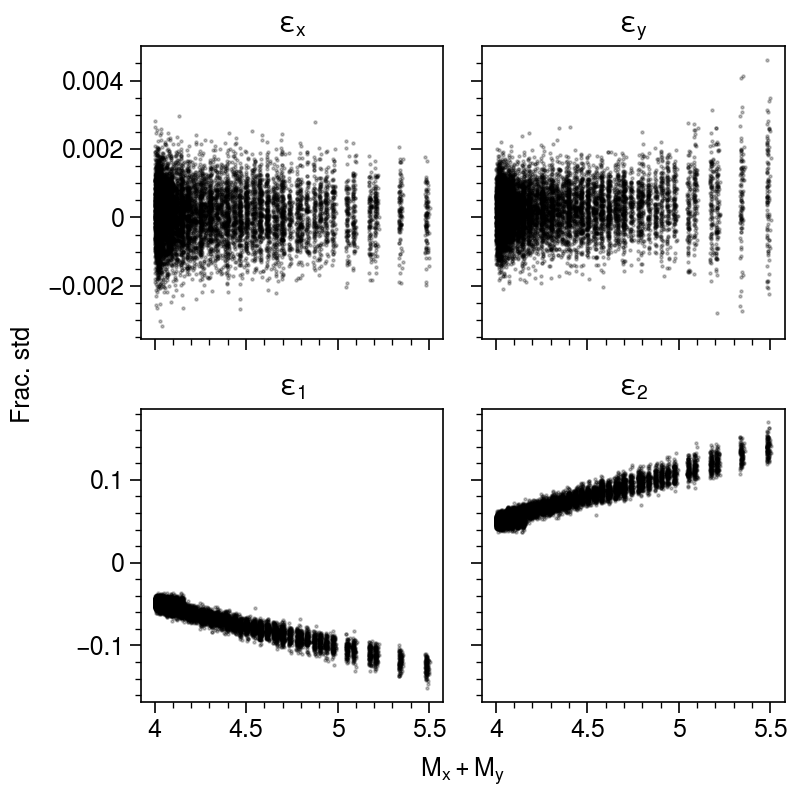

In [15]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(4.0, 4.0))
for i, (eps_label, ax) in enumerate(zip(eps_labels, axes)):
    x = M.ravel()
    y = frac_errs[..., i].values.ravel()
    ax.scatter(x, y, c='black', s=1, alpha=0.25)
    ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. std', title=eps_label)
    correct_xlim(ax)
plt.show()

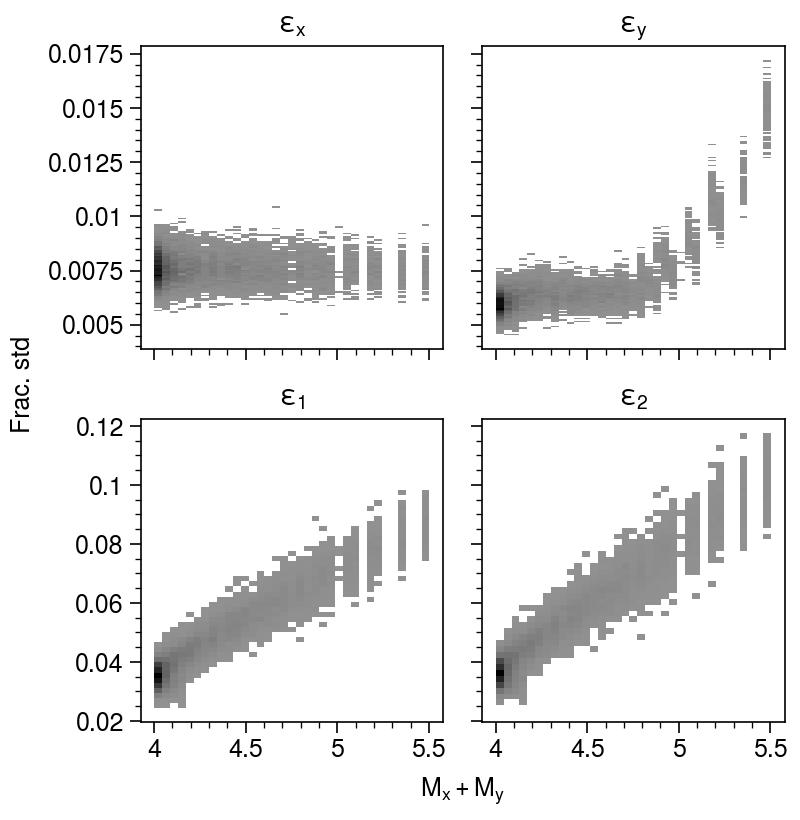

In [16]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figwidth=4.0)
for i, (eps_label, ax) in enumerate(zip(eps_labels, axes)):
    x = M.ravel()
    y = frac_stds[..., i].values.ravel()
    sns.histplot(x=x, y=y, ax=ax, cmap=cmap, ec='None')
    ax.format(xlabel=r'$M_x + M_y$', ylabel='Frac. std', title=eps_label)
    correct_xlim(ax)
plt.show()

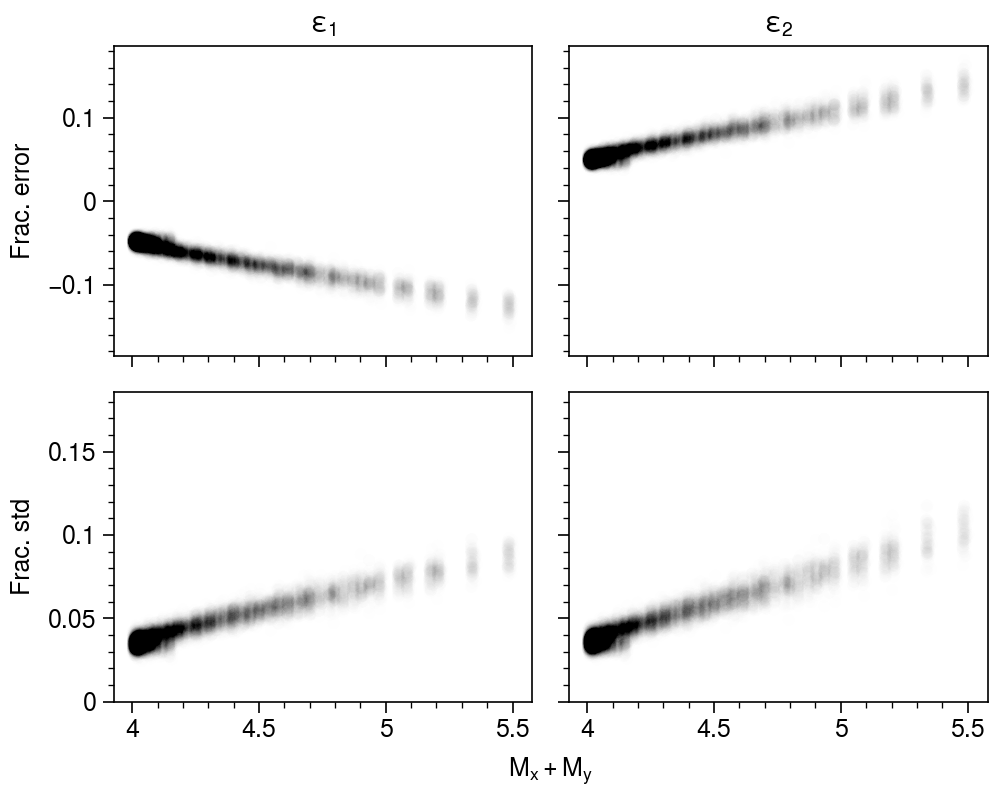

In [66]:
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(5.0, 4.0), spany=False, aligny=True)
kws = dict(c='black', s=20.0, ec='None', alpha=0.005)
x = M.ravel()
for j in range(2):
    for i, data in enumerate([frac_errs, frac_stds]):
        y = data[..., j + 2].values.ravel()
        axes[i, j].scatter(x, y, **kws)
axes.format(xlabel=r'$M_x + M_y$')
axes[0, 0].format(ylabel='Frac. error')
axes[1, 0].format(ylabel='Frac. std')
for ax, label in zip(axes[0, :], eps_labels[2:]):
    ax.set_title(label)
axes[1, :].format(ylim=(0., ax.get_ylim()[1]))
ylim = axes[0, 0].get_ylim()
ymax = max(np.abs(ylim))
axes[0, :].format(ylim=(-ymax, ymax))
plt.savefig('_output/figures/mismatch.png', dpi=400)
plt.show()